In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

/home/b.y.yang/miniconda3/envs/ese5934/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load trained model

In [3]:
# device = 'cuda:1'
device = "cpu"
conf = brats_autoenc()
print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0



Model params: 122.59 M


# Define test dataset

In [4]:
# class GrayscaleToRGBd(MapTransform):
#     def __init__(
#         self,
#         keys: KeysCollection,
#         allow_missing_keys: bool = False,
#     ) -> None:

#         super().__init__(keys, allow_missing_keys)
#         # self.grayscale_to_rgb = GrayscaleToRGB()

#     def __call__(
#         self, data: Mapping[Hashable, np.ndarray]
#     ) -> Dict[Hashable, np.ndarray]:
#         d = dict(data)
#         for key in self.key_iterator(d):
#             # squeeze img
#             img = d[key].squeeze()

#             # ensure that img is 2D
#             if not np.ndim(img) == 2:
#                 raise ValueError("Image dimensions must be equal to 2")

#             # repeat grayscale image along first dimension (color channel)
#             d[key] = np.tile(img, (3,1,1))
#         return d

# class Squeeze2Dd(MapTransform):
#     def __init__(
#         self,
#         keys: KeysCollection,
#         allow_missing_keys: bool = False,
#     ) -> None:

#         super().__init__(keys, allow_missing_keys)

#     def __call__(
#         self, data: Mapping[Hashable, np.ndarray]
#     ) -> Dict[Hashable, np.ndarray]:
#         d = dict(data)
#         for key in self.key_iterator(d):
#             # first squeeze
#             img = (d[key]).squeeze()

#             # ensure that img is 2D
#             if not np.ndim(img) == 2:
#                 raise ValueError("Image dimensions must be equal to 2")

#             # reshape to (1, img.shape[0], img.shape[1])
#             img = img.reshape((1, *img.shape))

#             d[key] = img
#         return d

# define transforms
bbox_slice_row = slice(22, 216, None)
bbox_slice_col = slice(29, 223, None)
transform_seq = Compose([
    LoadImaged(keys = ["img"]),
    Squeeze2Dd(keys = ["img"]),
    SpatialCropd(keys = ["img"], roi_slices = [bbox_slice_row, bbox_slice_col, slice(None)]),
    ScaleIntensityd(keys = ["img"]),
    Resized(keys = ["img"], spatial_size = (128, 128), size_mode = "all"),  # resize to 1 x 128 x 128
    GrayscaleToRGBd(keys = ["img"]),
    ToTensord(keys = ["img"]),
])

In [5]:
cache_dir = mkdtemp(dir = "/scratch/b.y.yang")
dataset_df = pd.read_csv("/scratch/b.y.yang/ESE5934-project/data/dataset.csv")
dataset_df = dataset_df.iloc[:2, :]
test_data = PersistentDataset(
    data = [{"img": nii_path} for nii_path in dataset_df["slice_path"]],
    transform = transform_seq,
    cache_dir = cache_dir
)

In [9]:
# store latent features
latent_features = np.zeros((2,512))
for i, x in enumerate(test_data):
    # get image
    img = x["img"][None, :]

    # encode
    cond = model.encode(img.to(device))

    # store latent features as numpy array
    latent_features[i, :] = cond[0].numpy().squeeze()

In [16]:
# data = ImageDataset('imgs_interpolate', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    test_data[0]['img'],
    test_data[1]['img'],
])

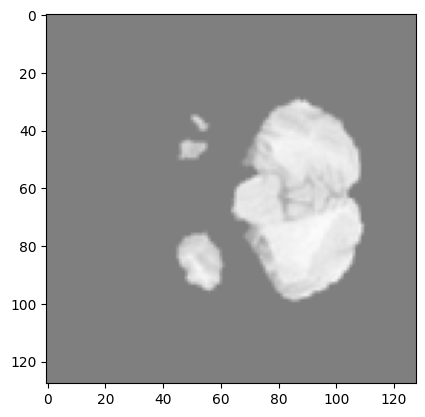

In [17]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

In [18]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

/home/b.y.yang/miniconda3/envs/ese5934/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


2023-03-23 12:36:14,947 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


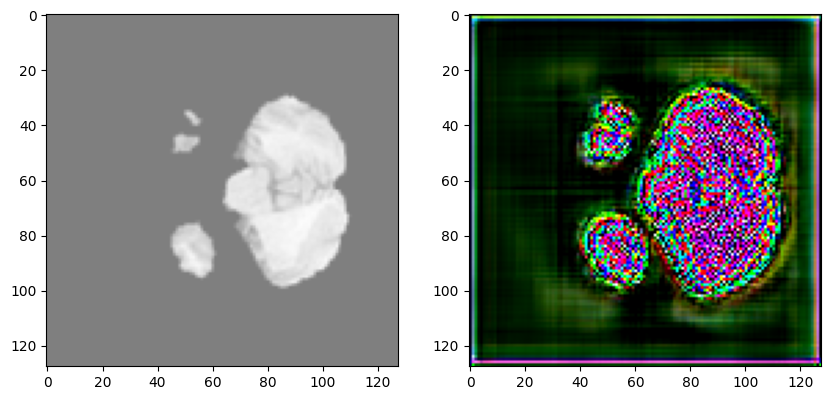

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [27]:
cond.shape

torch.Size([2, 512])

In [28]:
cond[1,:]

tensor([-0.6884, -0.0712,  0.1370, -0.1482, -0.4151,  0.6187,  1.6422,  0.2696,
        -0.2367,  0.0641, -1.2774, -1.1227,  1.2315,  0.0327, -1.2311,  0.2988,
        -1.2751, -1.1983, -1.1023, -1.0001,  0.1236,  0.1754,  0.7235, -0.0835,
        -1.0514,  0.0128,  1.3101, -1.1966,  0.4391,  0.1532, -0.1937,  0.1390,
        -1.2437, -0.1632, -0.2644,  1.4486,  0.3062, -0.7269,  0.1513, -0.6442,
        -0.3927, -0.4384, -0.0754, -1.2552, -0.2928, -0.0117,  0.0785,  0.0503,
        -0.0694, -1.1802, -0.3722,  0.0605,  0.3408, -0.1908,  0.0562, -0.0603,
         0.3360, -1.2643,  0.2675, -1.0899, -0.9950, -0.0389, -0.1634, -0.7888,
        -1.4958, -0.2199, -0.0592,  0.4496, -0.1115,  0.2122,  0.3190, -0.5479,
         0.0146, -0.5437, -0.3001,  0.1984, -1.4899, -0.1360, -0.1921, -1.3038,
        -1.1720, -0.2174, -1.1342, -0.3240,  0.3059,  0.0896,  0.5975,  0.0055,
         0.3446,  0.0796,  0.7248, -1.4172, -0.3363,  0.4252, -0.1610, -0.2466,
         0.4520,  0.0362, -1.2134,  0.41

In [24]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=20)

/home/b.y.yang/miniconda3/envs/ese5934/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


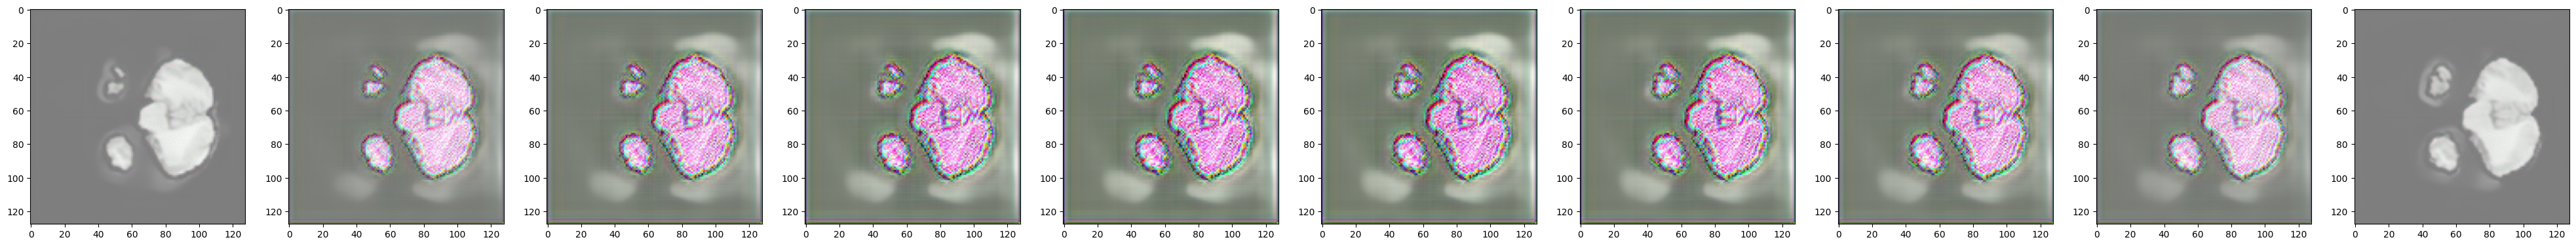

In [25]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
# plt.savefig('imgs_manipulated/compare.png')